In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import datetime as dt

In [3]:
#pobieranie CZĘŚCIOWO WYCZYSZCZONYCH danych

train_path = r"C:\Users\weron\Studia\Semestr 5\Fakultet biblioteki Pythona\Projekt\data\house-prices-advanced-regression-techniques\train_postprocessed.csv"
test_path = r"C:\Users\weron\Studia\Semestr 5\Fakultet biblioteki Pythona\Projekt\data\house-prices-advanced-regression-techniques\test_postprocessed.csv"

train_og = pd.read_csv(train_path)
test_og = pd.read_csv(test_path)

train = train_og.copy()
test = test_og.copy()

In [4]:
#podział na kolumny numeryczne i kategoryczne
X_train = train.drop(['SalePrice', 'Id'], axis=1)
y_train = train['SalePrice']
X_test = test.drop('Id', axis=1).copy()


num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns



In [5]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
#tutaj tak naprawdę simpleimputer nie jest potrzebny, do wczytywane dane mają braki 'obrobione' (plik data.py)
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])                                                            
#handle_unknown='ignore'  -->   #wychodziły błędy w kolumnie 'Street' dla testu, podobno miał wartości, które nie pojawiły się wcześniej w train, a skoro 'Street' nie wydaje się być bardzo wpływającą na wartość domu kolumną, wartości, które nie pojawiały się wcześniej w train będą w test jako 0 
#drop='first' --> zapobiega kolinearności, ważny krok, jeśli chcemy robić regresję 
#sparse_output=False --> żeby był czytelny df zamiast macierzy rzadkiej

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='passthrough', #dodatkowo dodane, tak naprawdę nie mamy kolumn poza num i cat, więc ten krok można pominąć
    verbose_feature_names_out=False #skracanie nowych nazw kolumn
)




In [24]:
cols_to_check = [
    'BsmtFinSF2', '2ndFlrSF', 'BsmtFullBath', 'LowQualFinSF', 'MiscVal',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'
] #wydaje mi się, że są puste (w sensie wszystkie wartosci=0, bo to są już dane bez pustek)

zero_counts = (X_train[cols_to_check] == 0).sum()

print(zero_counts)
"""EnclosedPorch     True
3SsnPorch         True
ScreenPorch       True
PoolArea          True"""



BsmtFinSF2       1100
2ndFlrSF          635
BsmtFullBath      644
LowQualFinSF     1100
OpenPorchSF       500
EnclosedPorch    1100
3SsnPorch        1100
ScreenPorch      1100
PoolArea         1100
dtype: int64


'EnclosedPorch     True\n3SsnPorch         True\nScreenPorch       True\nPoolArea          True'

In [6]:
#feature engineering własnej roboty

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_threshold = 0.9):
        self.drop_thresh = drop_threshold 
        self.cols_to_drop = []

    def fit(self, X, y=None):
        self.cols_to_drop = X.columns[(X.isna().mean() > self.drop_thresh) |
                                      ((X.select_dtypes(include=['int64', 'float64']) == 0).mean() > self.drop_thresh)]
        return self

    def transform(self, X):
        X = X.copy()

        X.drop(columns=self.cols_to_drop, inplace=True, errors='ignore')
        
        #logarytmowanie
        if 'LotArea' in X.columns:
            X['log_LotArea'] = np.log1p(X['LotArea'])
        if 'LotFrontage' in X.columns:
            X['log_LotFrontage'] = np.log1p(X['LotFrontage'])
        if 'MasVnrArea' in X.columns:
            X['log_MasVnrArea'] = np.log1p(X['MasVnrArea']) #ta cecha dostanie też flagę, bo jest dużo zer 
            X['HasMasVnrArea'] = (X['MasVnrArea'] > 0).astype('float64') #flaga
            #nie wiem jeszcze czy to dobry ruch, usuniemy og MasVnrArea 
            X = X.drop(['MasVnrType'], axis=1) 
        if 'WoodDeckSF' in X.columns:
            X['log_WoodDeckSF'] = np.log1p(X['WoodDeckSF']) #ta cecha dostanie też flagę, bo jest dużo zer 
            X['HasWoodDeckSF'] = (X['WoodDeckSF'] > 0).astype('float64') #flaga
            X = X.drop(['WoodDeckSF'], axis=1)

        #wiek garażu
        if 'GarageYrBlt' in X.columns:
            X['GarageAge'] = dt.now().year - X['GarageYrBlt']
            X = X.drop(['GarageYrBlt'], axis=1)

        #wiek domu od sprzedaży 
        if all(col in X.columns for col in ['YrSold', 'YearRemodAdd', 'YearBuilt']):
            X['AgeAtSold'] = X['YrSold'] - X['YearBuilt']
            X['YearsSinceRemod'] = X['YrSold'] - X['YearRemodAdd'] 
            X['HouseAge'] = dt.now().year - X['YearBuilt']
            X = X.drop(['YearBuilt', 'YearRemodAdd', 'YrSold'], axis=1)

        #sezonowość
        if 'MoSold' in X.columns:
            X['MoSold_sin'] = np.sin(2 * np.pi * X['MoSold'] / 12)
            X['MoSold_cos'] = np.cos(2 * np.pi * X['MoSold'] / 12)
            
            high_season_months = [4, 5, 6, 7, 8]  
            X['HighSeasonSell'] = X['MoSold'].isin(high_season_months).astype('int64')
            X = X.drop(['MoSold'], axis=1)

        #interakcja
        if 'GrLivArea' in X.columns and 'TotalBsmtSF' in X.columns:
            X['GrBsmtArea'] = X['GrLivArea'] + X['TotalBsmtSF']
            X = X.drop(['TotalBsmtSF'], axis=1)

        if all(col in X.columns for col in ['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath']):
            X['Bathrooms'] = X['FullBath'] + X['BsmtFullBath'] + 0.5*(X['HalfBath'] + X['BsmtHalfBath'])
            X = X.drop(['BsmtHalfBath', 'BsmtFullBath', 'FullBath', 'HalfBath'], axis=1)


        if all(col in X.columns for col in ['OverallQual', 'OverallCond']):
            X['QualGroup'] = pd.cut(X['OverallQual'], bins=[1,4,6,8,11], labels=['Low','Med','High','VeryHigh'])
            X['CondGroup'] = pd.cut(X['OverallCond'], bins=[1,4,6,8,10], labels=['Low','Med','High','VeryHigh'])
            X['QualCondScore'] = X['OverallQual'] * X['OverallCond']
        
        return X

In [33]:
X_train['SaleCondition']

0        Normal
1        Normal
2        Normal
3       Abnorml
4        Normal
         ...   
1095    Abnorml
1096     Normal
1097     Normal
1098     Normal
1099     Normal
Name: SaleCondition, Length: 1100, dtype: object

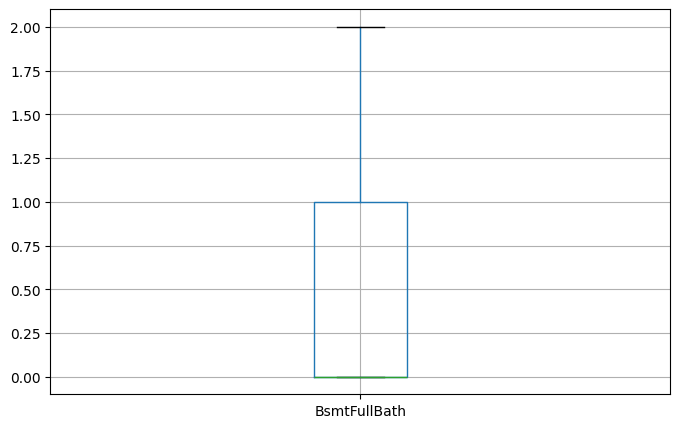

In [10]:
import matplotlib.pyplot as plt
#oglądanie wykresów, żeby stwierdzić, czy należy logarytmować
plt.figure(figsize=(8,5))
X_train.boxplot(column='BsmtFullBath')
plt.show()

In [ ]:
#pipeline'y

pipeline_log_reg = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
]).set_output(transform="pandas")

In [13]:


#dopasowanie pipeline'a na danych treningowych
pipeline_log_reg.fit(X_train, y_train)

#transformacja danych treningowych
X_train_prepared_log_reg = pipeline_log_reg.transform(X_train)

#transformacja danych testowych
X_test_prepared_log_reg = pipeline_log_reg.transform(X_test)


C:\Users\weron\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [9, 12, 14, 17, 18, 24, 29, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


In [15]:
X_train_prepared

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.153621,-0.140340,-0.164417,0.786676,-0.565094,1.045762,0.864384,0.931180,0.714662,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.910840,0.758928,0.194288,-0.029686,2.247590,0.109343,-0.450050,-0.654048,1.404126,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.153621,0.039513,0.708953,0.786676,-0.565094,0.976398,0.815701,0.656191,0.157007,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.419736,-0.440096,0.178692,0.786676,-0.565094,-2.006269,-0.742146,-0.654048,-0.527387,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.153621,0.998733,1.647826,1.603037,-0.565094,0.941716,0.718336,2.176716,0.585388,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-0.910840,1.358440,2.570167,-0.846048,-0.565094,1.149809,1.010432,-0.654048,-1.074902,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1096,-0.910840,-0.320194,-0.460739,0.786676,-0.565094,1.080444,0.961750,-0.654048,-0.035637,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1097,0.153621,-0.320194,-0.330670,-0.029686,-0.565094,0.907033,0.718336,-0.654048,-1.074902,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1098,-0.910840,1.058684,1.309395,-0.029686,0.372468,0.178708,0.134143,0.308412,0.927585,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
